In [0]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn
import torch.nn.functional as F
import numpy as np
import torch

In [2]:
dataset = fetch_california_housing()

In [3]:
dataset.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [4]:
len(dataset.target)

20640

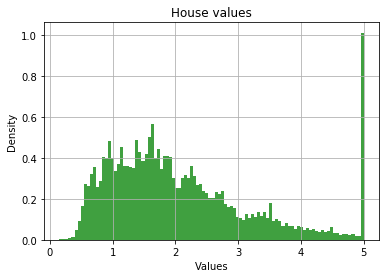

In [5]:
import matplotlib.pyplot as plt

mu, sigma = 100, 15

# the histogram of the data
n, bins, patches = plt.hist(dataset.target, 100, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Values')
plt.ylabel('Density')
plt.title('House values')
plt.grid(True)
plt.show()

In [0]:
train_X, test_X, train_y, test_y = train_test_split(dataset.data, dataset.target, test_size=0.2)

scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
train_y, test_y = train_y.reshape(-1, 1), test_y.reshape(-1, 1)
min_, max_ = train_y.min(), train_y.max()
train_y = (train_y - min_)/(max_ - min_)

test_X = scaler.transform(test_X)

train_X, train_y = torch.from_numpy(train_X).float(), torch.from_numpy(train_y).float()
test_X, test_y = torch.from_numpy(test_X).float(), torch.from_numpy(test_y).float()

In [0]:
train_set = TensorDataset(train_X, train_y)
test_set = TensorDataset(test_X, test_y)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32)

In [0]:
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Model, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(out))
        out = self.layer3(out)
        return out

In [0]:
device = torch.device("cuda")

model = Model(8, 128)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [10]:
epochs = 10

model.train()
for e in range(epochs):
    for i, (batch_X, batch_y) in enumerate(train_loader):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        predict = model(batch_X)
        
        optimizer.zero_grad()
        loss = criterion(predict, batch_y)
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            loss = loss.item()
            loss
            print(f"{e}epochs, {i} iters - {loss}")

0epochs, 0 iters - 0.2681405544281006
0epochs, 100 iters - 0.01942303404211998
0epochs, 200 iters - 0.029381152242422104
0epochs, 300 iters - 0.018005911260843277
0epochs, 400 iters - 0.01724792644381523
0epochs, 500 iters - 0.011333348229527473
1epochs, 0 iters - 0.012320045381784439
1epochs, 100 iters - 0.019448719918727875
1epochs, 200 iters - 0.01267432700842619
1epochs, 300 iters - 0.027402669191360474
1epochs, 400 iters - 0.012935129925608635
1epochs, 500 iters - 0.01979910023510456
2epochs, 0 iters - 0.011996826156973839
2epochs, 100 iters - 0.009244395419955254
2epochs, 200 iters - 0.01125320978462696
2epochs, 300 iters - 0.013184430077672005
2epochs, 400 iters - 0.007596876937896013
2epochs, 500 iters - 0.02108028344810009
3epochs, 0 iters - 0.01621505245566368
3epochs, 100 iters - 0.00991508923470974
3epochs, 200 iters - 0.011201777495443821
3epochs, 300 iters - 0.027855517342686653
3epochs, 400 iters - 0.010374639183282852
3epochs, 500 iters - 0.015266905538737774
4epochs, 0

In [11]:
total_loss = []
test_num = 0

with torch.no_grad():
    model.eval()
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predict = model(batch_X)
        predict = predict*(max_ - min_) + min_
        loss = F.l1_loss(predict, batch_y)

        batch_size = batch_y.size(0)
        test_num += batch_size
        total_loss.append(loss.item()*batch_size)

total_loss = np.sum(total_loss)/test_num
print(f"{e}epochs - {total_loss}")

9epochs - 0.3805211584928424


In [0]:
torch.save(model.state_dict(), './model.pth')

In [0]:
model.load_state_dict(torch.load('./model.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])